# Set Paths

In [26]:
!export PATH=$PATH:.
#base_path="/home/azureuser/Intelligent-Liquidity-Provisioning-Framework"
base_path="/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/Intelligent-Liquidity-Provisioning-Framework-V1"
import os
os.chdir(base_path)
os.environ["PATH"] += ":."
reset_env_var=False

# Reset Env

In [27]:
def reset_env():
    import shutil
    import os
    import json

    # Define the paths
    folder_path = os.path.join(base_path, "v3_core/build/deployments")
    json_file1_path = os.path.join(base_path, "model_storage/token_pool_addresses.json")
    json_file2_path = os.path.join(base_path, "model_storage/liq_positions.json")

    # 1. Delete the folder and its contents
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

    # 2. Delete contents of the first JSON file
    with open(json_file1_path, 'w') as file:
        file.write("{}")

    # 3. Delete contents of the second JSON file and add {}
    with open(json_file2_path, 'w') as file:
        file.write("{}")
        
if reset_env_var==True:
    reset_env()

# Env Setup

In [28]:
from netlists.uniswapV3.netlist import SimStrategy,SimState,netlist_createLogData
from engine.SimEngine import SimEngine
from util.globaltokens import weth_usdc_pool,eth_dai_pool,btc_usdt_pool
import brownie
from util.constants import GOD_ACCOUNT,RL_AGENT_ACCOUNT
from util.base18 import toBase18, fromBase18,fromBase128,price_to_valid_tick
from model_scripts.plot import train_rewards_plot,eval_rewards_plot,train_raw_actions_plot,train_scaled_actions_plot,train_combined_metrics_plot,train_separate_episode_action_plot
from model_scripts.sync_pool_subgraph_data import fetch_inference_pool_data
#Imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Training env

In [29]:
class DiscreteSimpleEnv(gym.Env):
    def __init__(self, agent_budget_usd=10000,alpha = 0.5, exploration_std_dev = 0.01, beta=0.1,penalty_param_magnitude=-1,use_running_statistics=False,action_transform='linear'):
        super(DiscreteSimpleEnv, self).__init__()

        self.pool=None
        self.global_state=None
        self.curr_price=None
        self.action_lower_bound=None
        self.action_upper_bound=None
        self.state=None
        self.engine=None
        self.action_transform=action_transform
        self.train_data_log=[]
        
        self.action_space = gym.spaces.Dict({
            'price_relative_lower': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'price_relative_upper': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })
        
        self.reward=0
        self.cumulative_reward = 0
        self.done=False
        self.episode=0
        self.step_count=0

        self.observation_space = gym.spaces.Dict({
            'scaled_curr_price': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_liquidity': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal0x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal1x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),   
        })
        self.agent_budget_usd = agent_budget_usd
        self.initial_budget_usd = agent_budget_usd

        # Initialize rewrad normalization running statistics
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        self.exploration_std_dev = exploration_std_dev
        self.penalty=0
        self.penalty_param=0
        self.penalty_param_magnitude=penalty_param_magnitude

        # Initialize running statistics for state normalization
        self.use_running_statistics=use_running_statistics
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0

        #Obs space scaling param
        self.alpha = alpha
        #Rewrad scaling param
        self.beta=beta
        
    def reset(self):
        self.pool=random.choice([weth_usdc_pool,eth_dai_pool,btc_usdt_pool])
        
        print(f'Pool selcted for this episode: {self.pool.pool_id}')
        sim_strategy = SimStrategy()
        sim_state = SimState(ss=sim_strategy,pool=self.pool)

        output_dir = "model_outdir_csv"
        netlist_log_func = netlist_createLogData

        #from engine.SimEngine import SimEngine
        self.engine = SimEngine(sim_state, output_dir, netlist_log_func)

        self.global_state=self.pool.get_global_state()
        self.curr_price=self.global_state['curr_price']
        self.action_lower_bound=self.curr_price*0.1
        self.action_upper_bound=self.curr_price*2
        self.state = self.get_obs_space()
        
        self.done=False
        self.reward=0
        self.cumulative_reward = 0
        self.episode+=1
        self.step_count=0
    
        # Used for evaluation only
        self.cumulative_reward_rl_agent = 0
        self.cumulative_reward_baseline_agent = 0

        self.agent_budget_usd = self.initial_budget_usd
         
        # reset running statistics for reward normalization
        '''
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0
        '''
        # reset running statistics for state normalization
        '''
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        '''  
        return self.state

    def step(self, raw_action):
              
        # Execute agent's action using pool's interface of add/remove liquidity
        mint_tx_receipt,action=self._take_action(raw_action)
        
        # run uniswap abm env of n_steps
        print()
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()
        
        self.state=self.get_obs_space()

        scaled_reward,raw_reward,fee_income,impermanent_loss = self._calculate_reward(action,mint_tx_receipt)
        self.reward=scaled_reward
        self.cumulative_reward += self.reward

        self.step_count+=1
        
        print(f"episode: {self.episode}, step_count: {self.step_count}, scaled_reward: {self.reward}, raw_reward: {raw_reward} cumulative_reward: {self.cumulative_reward}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()

        self.train_data_log.append((self.episode, self.step_count, action, self.pool.get_global_state(), raw_action, self.state, raw_reward, self.reward, self.cumulative_reward, fee_income, impermanent_loss))

        self.done = self._is_done()
        return self.state, self.reward, self.done, {}

    def get_obs_space(self):
        self.global_state = self.pool.get_global_state()

        # Scaling for curr_price and liquidity
        curr_price = float(self.global_state['curr_price'])
        liquidity = float(self.global_state['liquidity_raw'])
        fee_growth_0 = float(self.global_state['feeGrowthGlobal0X128'])
        fee_growth_1 = float(self.global_state['feeGrowthGlobal1X128'])

        self.curr_price_mean = self.alpha * curr_price + (1 - self.alpha) * self.curr_price_mean
        self.curr_price_std = np.sqrt(self.alpha * (curr_price - self.curr_price_mean)**2 + (1 - self.alpha) * self.curr_price_std**2)

        self.liquidity_mean = self.alpha * liquidity + (1 - self.alpha) * self.liquidity_mean
        self.liquidity_std = np.sqrt(self.alpha * (liquidity - self.liquidity_mean)**2 + (1 - self.alpha) * self.liquidity_std**2)

        # Scaling for fee growth differences 
        self.fee_growth_diff_0 = fee_growth_0 - self.previous_fee_growth_0
        self.fee_growth_diff_1 = fee_growth_1 - self.previous_fee_growth_1

        self.fee_growth_0_mean = self.alpha * self.fee_growth_diff_0 + (1 - self.alpha) * self.fee_growth_0_mean
        self.fee_growth_0_std = np.sqrt(self.alpha * (self.fee_growth_diff_0 - self.fee_growth_0_mean)**2 + (1 - self.alpha) * self.fee_growth_0_std**2)

        self.fee_growth_1_mean = self.alpha * self.fee_growth_diff_1 + (1 - self.alpha) * self.fee_growth_1_mean
        self.fee_growth_1_std = np.sqrt(self.alpha * (self.fee_growth_diff_1 - self.fee_growth_1_mean)**2 + (1 - self.alpha) * self.fee_growth_1_std**2)

        if self.use_running_statistics==True:
            #Use running stats
            obs = {'scaled_curr_price': (curr_price - self.curr_price_mean) / (self.curr_price_std + 1e-10),'scaled_liquidity': (liquidity - self.liquidity_mean) / (self.liquidity_std + 1e-10),}
            obs['scaled_feeGrowthGlobal0x128'] = (self.fee_growth_diff_0 - self.fee_growth_0_mean) / (self.fee_growth_0_std + 1e-10)
            obs['scaled_feeGrowthGlobal1x128'] = (self.fee_growth_diff_1 - self.fee_growth_1_mean) / (self.fee_growth_1_std + 1e-10)

        else:
            # Scale obs space using global stats
            obs = {'scaled_curr_price': curr_price/5000,'scaled_liquidity': liquidity/1e24,'scaled_feeGrowthGlobal0x128': fee_growth_0/1e34,'scaled_feeGrowthGlobal1x128': fee_growth_1/1e34}

        self.previous_fee_growth_0 = fee_growth_0
        self.previous_fee_growth_1 = fee_growth_1

        return obs

    def _take_action(self, action):
        self.penalty=0

        raw_a, raw_b = action[0, 0].numpy(), action[0, 1].numpy()

        # Add exploration noise
        a_0 = raw_a + np.random.normal(0, self.exploration_std_dev)
        a_1 = raw_b + np.random.normal(0, self.exploration_std_dev)
        
        if self.action_transform=='linear':
            a_0 = np.clip(a_0, 0, 1)
            a_1 = np.clip(a_1, 0, 1)
            price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)/2
            price_upper = (self.action_upper_bound - self.action_lower_bound)/2 + a_1 * (self.action_upper_bound - self.action_lower_bound)/2
        
            # Enabling agent to place range orders too (Only feasible when using multiple positions)
            #price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)
            #price_upper = self.action_lower_bound + a_1 * (self.action_upper_bound - self.action_lower_bound)
            
        elif self.action_transform=='exp':
            #Exponential transforom
            exp_a_0 = np.exp(a_0)
            exp_a_1 = np.exp(a_1)

            # Normalize the exponential values to the range [0, 1]
            norm_exp_a_0 = exp_a_0 / (exp_a_0 + exp_a_1)
            norm_exp_a_1 = exp_a_1 / (exp_a_0 + exp_a_1)

            # Calculate the range between action_lower_bound and action_upper_bound
            range_bound = self.action_upper_bound - self.action_lower_bound

            # Calculate price_lower and price_upper using the normalized exponential values
            price_lower = self.action_lower_bound + norm_exp_a_0 * range_bound
            price_upper = self.action_lower_bound + norm_exp_a_1 * range_bound

        
        # Ensure price_lower is less than price_upper - Add penalty
        
        if price_lower>price_upper:
            price_lower = min(price_lower, price_upper)
            price_upper = max(price_lower, price_upper)
            self.penalty=self.penalty_param_magnitude

        # ensure actions are not too close - Add penalty
        min_diff_percentage = 0.05  # 5% difference
        price_diff = price_upper - price_lower
        
        if price_diff < min_diff_percentage * price_lower:
            self.penalty+=self.penalty_param_magnitude
            price_upper = price_lower + min_diff_percentage * price_lower
        
        action_dict = {
            'price_lower': price_lower,
            'price_upper': price_upper
        }
        
        print('RL Agent Action')
        print(f"raw_action: {action}, scaled_action: {action_dict}")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd
        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
        
    def _calculate_reward(self,action,mint_tx_receipt):
       
        tick_lower=price_to_valid_tick(action['price_lower'],60)
        tick_upper=price_to_valid_tick(action['price_upper'],60)
        liquidity=mint_tx_receipt.events['Mint']['amount']

        # Collecting fee earned by position
        print('Collect fee')
        collect_tx_receipt,fee_income = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=True)
    
        print("Burn Position and Collect Tokens")
        # Remove position and collect tokens
        burn_tx_receipt=self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, liquidity)
        collect_tx_receipt,curr_budget_usd = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=False)

        # Can use online scaling approach as used for reward for this
        rel_portofolio_value = 1 - curr_budget_usd/self.agent_budget_usd
        
        # Instead of using full budget for next step use previous step's reomved liquidity amount as budget in next step
        #self.agent_budget_usd = curr_budget_usd
        
        # Calculate IL
        amount0_initial = mint_tx_receipt.events['Mint']['amount0']
        amount1_initial = mint_tx_receipt.events['Mint']['amount1']
        
        amount0_final = burn_tx_receipt.events['Burn']['amount0']
        amount1_final = burn_tx_receipt.events['Burn']['amount1']
        self.global_state = self.pool.get_global_state()
        pool_price = float(self.global_state['curr_price'])

        value_initial = (amount0_initial * pool_price + amount1_initial) / 1e18
        value_final = (amount0_final * pool_price + amount1_final) / 1e18

        impermanent_loss = value_initial - value_final

        if fee_income==0:
            self.penalty_param+= 0.05
            self.penalty += self.penalty_param_magnitude*(1+self.penalty_param)

        print(f'fee_earned:{fee_income}, impermannet_loss: {impermanent_loss}, penalty: {self.penalty}, initial_agent_portofolio_value: {value_initial}, final_agent_portofolio_value: {value_final}, reward_mean: {self.reward_mean}, rewrad_std_dev: {self.reward_std}, reward_count: {self.reward_count}')
        print()
        
        raw_reward = fee_income - impermanent_loss + self.penalty
        
        if self.penalty==0:
            self.reward_count += 1
            #new_mean = self.reward_mean + (raw_reward - self.reward_mean) / self.reward_count
            #new_std = ((self.reward_std ** 2 + (raw_reward - self.reward_mean) * (raw_reward - new_mean)) / self.reward_count) ** 0.5
            new_mean = self.beta * raw_reward + (1 - self.beta) * self.reward_mean
            new_std = np.sqrt(self.beta * ((raw_reward - new_mean) ** 2) + (1 - self.beta) * (self.reward_std ** 2))
            self.reward_mean = new_mean
            self.reward_std = new_std

        #scaled_reward = (raw_reward - self.reward_mean) / (self.reward_std + 1e-10)
        scaled_reward = raw_reward*10

        #Reset penlaty for next step
        self.penalty=0

        return scaled_reward,raw_reward,fee_income, impermanent_loss

    def _is_done(self):
        
        max_reward_threshold = 100000
        min_reward_threshold= -100000
        max_budget_threshold = 1.5*self.initial_budget_usd
        min_budget_threshold = 0.5*self.initial_budget_usd

        if self.cumulative_reward >= max_reward_threshold or self.cumulative_reward<=min_reward_threshold or self.agent_budget_usd>max_budget_threshold or self.agent_budget_usd<min_budget_threshold:
            return True
        else:
            return False

env=DiscreteSimpleEnv(agent_budget_usd=10000,use_running_statistics=False)
n_actions = sum(action_space.shape[0] for action_space in env.action_space.values())
input_dims = sum(np.prod(env.observation_space.spaces[key].shape) for key in env.observation_space.spaces.keys())

# RL Agents

## DDPG Agent

### Model

In [30]:
class ReplayBuffer:
    def __init__(self, max_size, input_dims, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_dims))
        self.new_state_memory = np.zeros((self.mem_size, input_dims))  
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        #print(f"action_memory:{self.action_memory}")

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones
    
    def clear(self):
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *self.state_memory.shape[1:]))
        self.new_state_memory = np.zeros((self.mem_size, *self.new_state_memory.shape[1:]))
        self.action_memory = np.zeros((self.mem_size, *self.action_memory.shape[1:]))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        
class DDPG_Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(DDPG_Actor, self).__init__()

        self.bn_input = tf.keras.layers.BatchNormalization()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.fc3 = tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='sigmoid')  # Two output units for 'price_lower' and 'price_upper'

    def call(self, state):
        state = self.bn_input(state)
        x = self.fc1(state)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        x = self.bn2(x)
        actions = self.output_layer(x)
        
        return actions
        
class DDPG_Critic(tf.keras.Model):
    def __init__(self, n_actions):
        super(DDPG_Critic, self).__init__()
        
        self.bn_state = tf.keras.layers.BatchNormalization()
        self.bn_action = tf.keras.layers.BatchNormalization()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.fc3 = tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.q = tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action):
        state = self.bn_state(state)
        action = self.bn_action(action)
        x = tf.concat([state, action], axis=1) 
        x = self.fc1(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        q = self.q(x)
        return q
    
class DDPG:
    def __init__(self, alpha=0.001, beta=0.002, input_dims=[8], tau=0.005, env=None,gamma=0.99, n_actions=2, max_size=1000000, batch_size=64,training=True,max_grad_norm=10):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = DDPG_Actor(n_actions=n_actions)
        self.critic = DDPG_Critic(n_actions=n_actions)
        self.target_actor = DDPG_Actor(n_actions=n_actions)
        self.target_critic = DDPG_Critic(n_actions=n_actions)

        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

        self.env = env
        self.training=training
        self.max_grad_norm=max_grad_norm

        # For tensorboard logging
        self.log_dir = os.path.join(base_path,'model_storage/tensorboard_ddpg_logs')
        self.train_summary_writer = tf.summary.create_file_writer(self.log_dir)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):
        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_new_state = self.flatten_state(new_state)
        self.memory.store_transition(flat_state, flat_action, reward, flat_new_state, done)
        
    def flatten_state(self,state_dict):
        scaled_curr_price = float(state_dict['scaled_curr_price'])
        scaled_liquidity = float(state_dict['scaled_liquidity'])
        scaled_fee_growth_0 = float(state_dict['scaled_feeGrowthGlobal0x128'])
        scaled_fee_growth_1 = float(state_dict['scaled_feeGrowthGlobal1x128'])
        
        return np.array([scaled_curr_price, scaled_liquidity, scaled_fee_growth_0, scaled_fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'scaled_curr_price': state_array[0],
            'scaled_liquidity': state_array[1],
            'scaled_feeGrowthGlobal0x128': state_array[2],
            'scaled_feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])
    
    def choose_action(self, state):
        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)
        raw_actions_tensor = self.actor(state_tensor,training=False)
        
        return raw_actions_tensor
        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        #print(f"{state},{action},{reward},{new_state}")
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_,training=False)
            critic_value_ = tf.squeeze(self.target_critic(states_, target_actions,training=False), 1)
            critic_value = tf.squeeze(self.critic(states, actions,training=True), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = tf.keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss, self.critic.trainable_variables)
        critic_network_gradient, _ = tf.clip_by_global_norm(critic_network_gradient, self.max_grad_norm)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states,training=True)
            actor_loss = -self.critic(states, new_policy_actions,training=True)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
        actor_network_gradient, _ = tf.clip_by_global_norm(actor_network_gradient, self.max_grad_norm)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradient, self.actor.trainable_variables))
        
        print(f"Actor_Loss: {actor_loss.numpy()}, Critic_Loss: {critic_loss.numpy()}")
       
        with self.train_summary_writer.as_default():
            tf.summary.scalar('critic_loss', critic_loss.numpy(), step=self.memory.mem_cntr)
            tf.summary.scalar('actor_loss', actor_loss.numpy(), step=self.memory.mem_cntr)


        self.update_network_parameters()

### Training

In [31]:
# Training Loop
def train_ddpg_agent(max_steps=100, n_episodes=10, model_name='model_storage/ddpg/lstm_actor_critic_batch_norm',alpha=0.001, beta=0.001, input_dims=input_dims, tau=0.8, env=env,n_actions=n_actions, batch_size=50, training=True,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear'):
    env=DiscreteSimpleEnv(agent_budget_usd=agent_budget_usd,use_running_statistics=use_running_statistics,action_transform=action_transform)
    ddpg_agent = DDPG(alpha=alpha, beta=beta, input_dims=input_dims, tau=tau, env=env, n_actions=n_actions, batch_size=batch_size, training=training)
    for i in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        
        for _ in range(max_steps):
            action = ddpg_agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            ddpg_agent.remember(state, action, reward, next_state, done)
            ddpg_agent.learn()
            state = next_state
            episode_reward += reward
            if done:
                break
        print(f"Episode {i+1}: Reward = {episode_reward}")
        #ddpg_agent.memory.clear()

    # Saved Trained weights
    model_base_path = os.path.join(base_path,model_name)
    ddpg_actor_model_path = os.path.join(model_base_path, 'actor')
    ddpg_critic_model_path = os.path.join(model_base_path, 'critic')
    ddpg_agent.actor.save_weights(ddpg_actor_model_path)
    ddpg_agent.critic.save_weights(ddpg_critic_model_path)
    ddpg_train_data_log=env.train_data_log
    return ddpg_train_data_log

#train_ddpg_agent(max_steps=100,n_episodes=10,model_name='model_storage/ddpg/lstm_actor_critic_batch_norm')

### Training Visulalizations

In [32]:
def ddpg_training_vis(ddpg_train_data_log):
    df_data = []

    for entry in ddpg_train_data_log:
        episode, step_count, scaled_action, raw_state, tensor_data, scaled_state, raw_reward, scaled_reward, cumulative_reward, fee_earned, impermanent_loss = entry
        
        # Extract raw_action values from tensor_data
        raw_action_0 = float(tensor_data[0][0].numpy())
        raw_action_1 = float(tensor_data[0][1].numpy())

        scaled_action_0 = scaled_action['price_lower']
        scaled_action_1 = scaled_action['price_upper']
        
        # Combine all data into a single dictionary
        data = {
            'episode': episode,
            'step_count': step_count,
            'scaled_action_0':scaled_action_0,
            'scaled_action_1':scaled_action_1,
            'raw_reward': raw_reward,
            'scaled_reward': scaled_reward,
            'fee_earned': fee_earned,
            'impermanent_loss': impermanent_loss,
            'cumulative_reward': cumulative_reward,
            'raw_action_0': raw_action_0,
            'raw_action_1': raw_action_1,
        }
        
        # Add raw_action, global_state, and state data
        #data.update(scaled_action)
        data.update(raw_state)
        data.update(scaled_state)
        
        df_data.append(data)

    ddpg_train_data_df = pd.DataFrame(df_data)
    ddpg_train_data_df.to_csv('model_outdir_csv/ddpg_agent_train_data.csv', index=False)

    train_rewards_plot(ddpg_train_data_df)
    train_raw_actions_plot(ddpg_train_data_df)
    train_scaled_actions_plot(ddpg_train_data_df)
    train_combined_metrics_plot(ddpg_train_data_df)
    #train_separate_episode_action_plot(ddpg_train_data_df)

## PPO Agent (Stochastic Policy)

### Model

In [33]:
class RolloutBuffer:
    def __init__(self, buffer_size, observation_dims, n_actions):
        self.states = np.zeros((buffer_size, observation_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, n_actions), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=bool)
        self.log_probs = np.zeros((buffer_size, n_actions), dtype=np.float32)
        self.values = np.zeros(buffer_size, dtype=np.float32)
        self.next_values = np.zeros(buffer_size, dtype=np.float32)
        self.ptr, self.max_size = 0, buffer_size
        self.buffer_size=buffer_size
        self.observation_dims=observation_dims
        self.n_actions=n_actions

        self.reset()

    def store_transition(self, state, action, reward, done, log_prob, value, next_value):
        index = self.ptr % self.max_size
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.dones[index] = done
        self.log_probs[index] = log_prob
        self.values[index] = value
        self.next_values[index] = next_value
        self.ptr += 1

    def sample(self):
        self.ptr = 0
        return (self.states, self.actions, self.rewards, self.dones, 
                self.log_probs, self.values, self.next_values)
    def reset(self):
        self.states = np.zeros((self.buffer_size, self.observation_dims), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_actions), dtype=np.float32)
        self.rewards = np.zeros(self.buffer_size, dtype=np.float32)
        self.dones = np.zeros(self.buffer_size, dtype=bool)
        self.log_probs = np.zeros((self.buffer_size, self.n_actions), dtype=np.float32)
        self.values = np.zeros(self.buffer_size, dtype=np.float32)
        self.next_values = np.zeros(self.buffer_size, dtype=np.float32)
        self.ptr = 0

    def is_full(self):
        return self.ptr >= self.buffer_size
    
class PPO_Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(PPO_Actor, self).__init__()

        self.bn_input = tf.keras.layers.BatchNormalization()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.fc3 = tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = tf.keras.layers.BatchNormalization()
        # Output the mean of the actions
        self.mu = tf.keras.layers.Dense(n_actions, activation='sigmoid')
        # Output the standard deviation of the actions (log std for numerical stability)
        self.sigma = tf.keras.layers.Dense(n_actions, activation='sigmoid')

    def call(self, state):
        state = self.bn_input(state)
        x = self.fc1(state)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        return mu, sigma
    
class PPO_Critic(tf.keras.Model):
    def __init__(self):
        super(PPO_Critic, self).__init__()

        self.bn_state = tf.keras.layers.BatchNormalization()
        self.fc1 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.fc3 = tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.q = tf.keras.layers.Dense(1, activation=None)

    def call(self, state):
        x = self.bn_state(state) 
        x = self.fc1(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = tf.expand_dims(x, axis=1)
        x = self.lstm2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        q = self.q(x)

        return q

class PPO:
    def __init__(self, env, n_actions,observation_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, buffer_size=64, max_grad_norm=0.5, n_epochs=1,training=True):
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.policy_clip = policy_clip
        self.buffer_size=buffer_size
        self.optimizer=tf.keras.optimizers.Adam(learning_rate=alpha)
        self.observation_dims=observation_dims
        self.max_grad_norm = max_grad_norm
        self.n_epochs=n_epochs
        
        self.actor = PPO_Actor(n_actions)
        self.critic = PPO_Critic()
        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))

        self.rollout_buffer = RolloutBuffer(self.buffer_size, observation_dims, n_actions)

        self.env=env
        self.training=training
        

         # For tensorboard logging
        self.log_dir = os.path.join(base_path,'model_storage/tensorboard_ppo_logs')
        self.train_summary_writer = tf.summary.create_file_writer(self.log_dir)
        self.tensorboard_counter=0
 
    def choose_action(self, state):

        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)

        mu, sigma = self.actor(state_tensor,training=self.training)
        
        action_prob = tfp.distributions.Normal(mu, sigma)
        action = action_prob.sample()
        
        #Action clipping
        #action = tf.clip_by_value(action, 0, 1)
        log_prob = action_prob.log_prob(action)
        print(f"mu: {mu}, sigma: {sigma}, action_prob: {action_prob}, action: {action}, log_prob: {log_prob}")
        return action,log_prob

    def remember(self, state, action, reward, next_state, done, log_prob):
        
        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_next_state = self.flatten_state(next_state)
        value = self.critic(tf.convert_to_tensor([flat_state], dtype=tf.float32))
        next_value = self.critic(tf.convert_to_tensor([flat_next_state], dtype=tf.float32))
        self.rollout_buffer.store_transition(flat_state, flat_action, reward, done, log_prob, value, next_value)
    
    def learn(self):
        states, actions, rewards, dones, old_log_probs, values, next_values = self.rollout_buffer.sample()
        returns, advantages = self.compute_gae(rewards, values, next_values, dones, self.gamma, self.gae_lambda)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        old_log_probs = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        # Update policy and value networks for a number of epochs
        for _ in range(self.n_epochs):
            with tf.GradientTape() as tape:
                total_loss = self.ppo_loss(states, actions, old_log_probs, advantages, returns, self.policy_clip)
            gradients = tape.gradient(total_loss, self.actor.trainable_variables + self.critic.trainable_variables)
            # Gradient clipping
            gradients, _ = tf.clip_by_global_norm(gradients, self.max_grad_norm)
            self.optimizer.apply_gradients(zip(gradients, self.actor.trainable_variables + self.critic.trainable_variables))
                
        self.rollout_buffer.reset()
       
    def compute_gae(self, rewards, values, next_values, dones, gamma=0.99, lam=0.95):
        gae = 0
        returns = np.zeros_like(rewards)
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + gamma * lam * (1 - dones[t]) * gae
            returns[t] = gae + values[t]
        advantages = returns - values
        return returns, (advantages - advantages.mean()) / (advantages.std() + 1e-10)

    def ppo_loss(self, states, actions, old_log_probs, advantages, returns, clip_param=0.2):
        mu, sigma = self.actor(states)
        values = tf.squeeze(self.critic(states))

        # Calculate new log probabilities using the updated policy
        new_policy = tfp.distributions.Normal(mu, sigma)
        new_log_probs = new_policy.log_prob(actions)

        # Policy loss
        ratios = tf.exp(new_log_probs - old_log_probs)
        #ratios = tf.reduce_mean(ratios, axis=1)
        advantages = tf.expand_dims(advantages, -1)
        surr1 = ratios * advantages
        surr2 = tf.clip_by_value(ratios, 1 - clip_param, 1 + clip_param) * advantages
        policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
        # Value loss
        value_loss = tf.reduce_mean(tf.square(returns - values))
        # Total loss
        total_loss = policy_loss + 0.5 * value_loss
        with self.train_summary_writer.as_default():
            tf.summary.scalar('total_loss', total_loss.numpy(), step=self.tensorboard_counter)
            tf.summary.scalar('policy_loss', total_loss.numpy(), step=self.tensorboard_counter)
            tf.summary.scalar('value_loss', total_loss.numpy(), step=self.tensorboard_counter)

        print(f"total_loss:{total_loss}, policy_loss:{policy_loss}, value_loss:{value_loss}, advantages:{advantages}, returns:{returns}")
        self.tensorboard_counter+=1
        return total_loss
          
    def flatten_state(self,state_dict):
        scaled_curr_price = float(state_dict['scaled_curr_price'])
        scaled_liquidity = float(state_dict['scaled_liquidity'])
        scaled_fee_growth_0 = float(state_dict['scaled_feeGrowthGlobal0x128'])
        scaled_fee_growth_1 = float(state_dict['scaled_feeGrowthGlobal1x128'])
        
        return np.array([scaled_curr_price, scaled_liquidity, scaled_fee_growth_0, scaled_fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'scaled_curr_price': state_array[0],
            'scaled_liquidity': state_array[1],
            'scaled_feeGrowthGlobal0x128': state_array[2],
            'scaled_feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])

    def map_indices_to_action_values(self, action_indices):
        action_dict = {
            'price_relative_lower': action_indices[0],
            'price_relative_upper': action_indices[1]
        }
        return action_dict

### Training

In [34]:
def train_ppo_agent(max_steps=100, n_episodes=10, model_name='model_storage/ppo/lstm_actor_critic_batch_norm', n_actions=n_actions, observation_dims=input_dims,buffer_size=50,n_epochs=10, gamma=0.5, alpha=0.01, gae_lambda=0.75, policy_clip=0.8, max_grad_norm=10,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear'):
    
    env=DiscreteSimpleEnv(agent_budget_usd=agent_budget_usd,use_running_statistics=use_running_statistics,action_transform=action_transform)
    ppo_agent = PPO(env, n_actions, observation_dims=input_dims,buffer_size=buffer_size,n_epochs=n_epochs, gamma=gamma, alpha=alpha, gae_lambda=gae_lambda, policy_clip=policy_clip, max_grad_norm=max_grad_norm)
    for i in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        
        for _ in range(max_steps):
            action,log_prob = ppo_agent.choose_action(state)
        

            next_state, reward, done, _ = env.step(action)

            ppo_agent.remember(state, action, reward, next_state, done,log_prob)

            state = next_state
            episode_reward += reward

            if ppo_agent.rollout_buffer.is_full():
                ppo_agent.learn()
            if done:
                break
        print(f"Episode {i+1}: Reward = {episode_reward}")

    ppo_model_base_path = os.path.join(base_path,model_name)
    ppo_actor_model_path = os.path.join(ppo_model_base_path, 'actor')
    ppo_critic_model_path = os.path.join(ppo_model_base_path, 'critic')
    ppo_agent.actor.save_weights(ppo_actor_model_path)
    ppo_agent.critic.save_weights(ppo_critic_model_path)
    ppo_train_data_log=env.train_data_log

    return ppo_train_data_pg


### Training Visulizations

In [35]:
def ppo_training_vis(ppo_train_data_log):
    df_data = []

    for entry in ppo_train_data_log:
        episode, step_count, scaled_action, raw_state, tensor_data, scaled_state, raw_reward, scaled_reward, cumulative_reward, fee_earned, impermanent_loss = entry
        
        # Extract raw_action values from tensor_data
        raw_action_0 = float(tensor_data[0][0].numpy())
        raw_action_1 = float(tensor_data[0][1].numpy())

        scaled_action_0 = scaled_action['price_lower']
        scaled_action_1 = scaled_action['price_upper']
        
        # Combine all data into a single dictionary
        data = {
            'episode': episode,
            'step_count': step_count,
            'scaled_action_0':scaled_action_0,
            'scaled_action_1':scaled_action_1,
            'raw_reward': raw_reward,
            'scaled_reward': scaled_reward,
            'fee_earned': fee_earned,
            'impermanent_loss': impermanent_loss,
            'cumulative_reward': cumulative_reward,
            'raw_action_0': raw_action_0,
            'raw_action_1': raw_action_1,
        }
        
        # Add raw_action, global_state, and state data
        #data.update(scaled_action)
        data.update(raw_state)
        data.update(scaled_state)
        
        df_data.append(data)

    ppo_train_data_df = pd.DataFrame(df_data)
    ppo_train_data_df.to_csv('model_outdir_csv/ppo_agent_train_data.csv', index=False)

    train_rewards_plot(ppo_train_data_df)
    train_raw_actions_plot(ppo_train_data_df)
    train_scaled_actions_plot(ppo_train_data_df)
    train_combined_metrics_plot(ppo_train_data_df)
    train_separate_episode_action_plot(ppo_train_data_df)

In [36]:
#%load_ext tensorboard
#%tensorboard --logdir ./model_storage

# Eval Env

In [37]:
class DiscreteSimpleEnvEval(DiscreteSimpleEnv):
    def __init__(self, agent_budget_usd, percentage_range=0.3, seed=32,penalty_param_magnitude=0,use_running_statistics=False,action_transform='linear'):
        #super().__init__(agent_budget_usd)
        # Call to the parent class's __init__ method
        super(DiscreteSimpleEnvEval, self).__init__(agent_budget_usd=agent_budget_usd, alpha=0.5, exploration_std_dev=0.01, beta=0.1, penalty_param_magnitude=penalty_param_magnitude, use_running_statistics=use_running_statistics,action_transform=action_transform)
        self.percentage_range = percentage_range
        if seed is not None:
            np.random.seed(seed)
        self.cumulative_reward_rl_agent = 0
        self.cumulative_reward_baseline_agent = 0
        self.penalty_param_magnitude=penalty_param_magnitude
        self.eval_data_log=[]

    def _take_action(self, action):
        # Disable exploration noise
        self.exploration_std_dev = 0.0
        return super()._take_action(action)
    
    def step(self, raw_action_rl_agent):
        # The RL agent takes an action
        mint_tx_receipt_rl_agent, action_rl_agent = self._take_action(raw_action_rl_agent)
        raw_action_baseline_agent=self.baseline_agent_policy()
        # The baseline agent takes an action
        mint_tx_receipt_baseline_agent, action_baseline_agent = self._take_action_baseline(raw_action_baseline_agent)

        # Perform environment step
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()

        # Calculate rewards for both agents
        scaled_reward_rl_agent, raw_reward_rl_agent, fee_income_rl_agent, impermanent_loss_rl_agent = self._calculate_reward(action_rl_agent, mint_tx_receipt_rl_agent)
        scaled_reward_baseline_agent, raw_reward_baseline_agent, fee_income_baseline_agent, impermanent_loss_baseline_agent = self._calculate_reward(action_baseline_agent, mint_tx_receipt_baseline_agent)

        # Update cumulative rewards
        self.cumulative_reward_rl_agent += scaled_reward_rl_agent
        self.cumulative_reward_baseline_agent += scaled_reward_baseline_agent

        self.step_count+=1
        # Print rewards and cumulative rewards for both agents
        print(f"episode: {self.episode}, step_count: {self.step_count}")
        print(f"rl_agent_scaled_reward: {scaled_reward_rl_agent}, rl_agent_raw_reward: {raw_reward_rl_agent}, rl_agent_cumulative_reward: {self.cumulative_reward_rl_agent}")
        print(f"baseline_agent_scaled_reward: {scaled_reward_baseline_agent}, baseline_agent_raw_reward: {raw_reward_baseline_agent}, baseline_agent_cumulative_reward: {self.cumulative_reward_baseline_agent}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()
      

        # Update the state and check if the episode is done
        self.state = self.get_obs_space()
        self.done = self._is_done()
        self.eval_data_log.append((self.episode, self.step_count, self.pool.get_global_state(), raw_action_rl_agent,action_rl_agent,raw_action_baseline_agent,action_baseline_agent, self.state, raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, self.cumulative_reward_rl_agent, self.cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent,fee_income_baseline_agent,impermanent_loss_baseline_agent))
        # Return the necessary information
        return self.state, raw_reward_rl_agent, self.done, {}
    
    def _take_action_baseline(self, action_dict):
        
        print('Baseline Agent Action')
        print(f"action: {action_dict}")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
    
    
    def baseline_agent_policy(self):
        global_state = self.pool.get_global_state()
        raw_curr_price = global_state['curr_price']
        
        # Calculate the price range based on the raw current price
        lower_price = raw_curr_price * (1 - self.percentage_range)
        upper_price = raw_curr_price * (1 + self.percentage_range)

        action_baseline={
            'price_lower':lower_price,
            'price_upper':upper_price
        }
        
        return action_baseline

class DDGPEval(DDPG):
    def choose_action(self, state):
        # Disable exploration noise
        action = super().choose_action(state)
        return action
    
class PPOEval(PPO):
    def choose_action(self, state):
        # Disable exploration noise
        action = super().choose_action(state)
        return action

# Policy Evaluation

## DDPG Eval

In [38]:
def eval_ddpg_agent(eval_steps=100,eval_episodes=2,model_name='model_storage/ddpg/200_100_step_running_stats_lstm_bn_global_obs_norm',percentage_range=0.5,agent_budget_usd=10000,use_running_statistics=False):    
    eval_env = DiscreteSimpleEnvEval(agent_budget_usd=agent_budget_usd,percentage_range=percentage_range, seed=42,use_running_statistics=use_running_statistics)
    ddpg_eval_agent = DDGPEval(env=eval_env, n_actions=n_actions, input_dims=input_dims, training=False)
    model_base_path = os.path.join(base_path,model_name)

    ddpg_actor_model_path = os.path.join(model_base_path, 'actor')
    ddpg_critic_model_path = os.path.join(model_base_path, 'critic')

    ddpg_eval_agent.actor.load_weights(ddpg_actor_model_path)
    ddpg_eval_agent.critic.load_weights(ddpg_critic_model_path)

    for episode in range(eval_episodes):
        state = eval_env.reset()
        episode_reward = 0
        
        for step in range(eval_steps):
            action = ddpg_eval_agent.choose_action(state)
            next_state, reward, done, _ = eval_env.step(action)
            
            episode_reward += reward
            state = next_state
            if done:
                break
        print(f"Episode {episode+1}/{eval_episodes}, Reward: {episode_reward}")
    ppo_eval_data_log=eval_env.eval_data_log
    return ppo_eval_data_log

In [39]:
def ddpg_eval_vis(ppo_eval_data_log):
    df_eval_data = []

    for entry in ppo_eval_data_log:
        (episode, step_count, global_state, raw_action_rl_agent, action_rl_agent, 
        raw_action_baseline_agent, action_baseline_agent, state, 
        raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, cumulative_reward_rl_agent, 
        cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent, 
        fee_income_baseline_agent, impermanent_loss_baseline_agent) = entry
        
        # Extract raw_action values for RL agent
        raw_action_rl_agent_0 = float(raw_action_rl_agent[0][0].numpy())
        raw_action_rl_agent_1 = float(raw_action_rl_agent[0][1].numpy())

        scaled_action_rl_agent_0 = action_rl_agent['price_lower']
        scaled_action_rl_agent_1 = action_rl_agent['price_upper']
        
        # Extract raw_action values for baseline agent
        raw_action_baseline_agent_0 = raw_action_baseline_agent['price_lower']
        raw_action_baseline_agent_1 = raw_action_baseline_agent['price_upper']
        
        # Combine all data into a single dictionary
        data = {
            'episode': episode,
            'step_count': step_count,
            'raw_reward_rl_agent': raw_reward_rl_agent,
            'scaled_reward_rl_agent':scaled_reward_rl_agent,
            'cumulative_reward_rl_agent': cumulative_reward_rl_agent,
            'scaled_action_rl_agent_0':scaled_action_rl_agent_0,
            'scaled_action_rl_agent_1':scaled_action_rl_agent_1,
            'fee_income_rl_agent': fee_income_rl_agent,
            'impermanent_loss_rl_agent': impermanent_loss_rl_agent,
            'raw_reward_baseline_agent': raw_reward_baseline_agent,
            'scaled_reward_baseline_agent':scaled_reward_baseline_agent,
            'cumulative_reward_baseline_agent': cumulative_reward_baseline_agent,
            'raw_action_baseline_agent_0': raw_action_baseline_agent_0,
            'raw_action_baseline_agent_1': raw_action_baseline_agent_1,
            'fee_income_baseline_agent': fee_income_baseline_agent,
            'impermanent_loss_baseline_agent': impermanent_loss_baseline_agent,
            'raw_action_rl_agent_0': raw_action_rl_agent_0,
            'raw_action_rl_agent_1': raw_action_rl_agent_1,

        }
        
        # Add action, global_state, and state data
        
        data.update(global_state)
        data.update(state)
        
        df_eval_data.append(data)

    ddpg_eval_data_df = pd.DataFrame(df_eval_data)
    ddpg_eval_data_df.to_csv('model_outdir_csv/ddpg_agent_eval_data.csv', index=False)
    eval_rewards_plot(ddpg_eval_data_df)

## PPO Eval

In [40]:
def eval_ppo_agent(eval_steps=100, eval_episodes=2, model_name='model_storage/ppo/lstm_actor_critic_batch_norm',percentage_range=0.6,agent_budget_usd=10000, use_running_statistics=False):
    eval_env = DiscreteSimpleEnvEval(agent_budget_usd=agent_budget_usd,percentage_range=percentage_range, seed=42, penalty_param_magnitude=0, use_running_statistics=use_running_statistics)
    ppo_eval_agent = PPOEval(eval_env, n_actions, observation_dims=input_dims, buffer_size=5,training=False)

    #model_base_path = os.path.join(base_path,'model_storage/ppo/200_100_step_running_stats_lstm_bn_global_obs_norm')
    #ppo_actor_model_path = os.path.join(model_base_path, 'actor')
    #ppo_critic_model_path = os.path.join(model_base_path, 'critic')
    model_base_path = os.path.join(base_path,model_name)

    ppo_actor_model_path = os.path.join(model_base_path, 'actor')
    ppo_critic_model_path = os.path.join(model_base_path, 'critic')

    ppo_eval_agent.actor.load_weights(ppo_actor_model_path)
    ppo_eval_agent.critic.load_weights(ppo_critic_model_path)

    for episode in range(eval_episodes):
        state = eval_env.reset()
        episode_reward = 0
        
        for step in range(eval_steps):
            action,_ = ppo_eval_agent.choose_action(state)
            next_state, reward, done, _ = eval_env.step(action)
            
            episode_reward += reward
            
            state = next_state
            if done:
                break
        print(f"Episode {episode+1}/{eval_episodes}, Reward: {episode_reward}")
    ppo_eval_data_log=eval_env.eval_data_log
    return ppo_eval_data_log

In [41]:
def ppo_eval_vis(ppo_eval_data_log):
    df_eval_data = []    
    for entry in ppo_eval_data_log:
        (episode, step_count, global_state, raw_action_rl_agent, action_rl_agent, 
        raw_action_baseline_agent, action_baseline_agent, state, 
        raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, cumulative_reward_rl_agent, 
        cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent, 
        fee_income_baseline_agent, impermanent_loss_baseline_agent) = entry
        
        # Extract raw_action values for RL agent
        raw_action_rl_agent_0 = float(raw_action_rl_agent[0][0].numpy())
        raw_action_rl_agent_1 = float(raw_action_rl_agent[0][1].numpy())

        scaled_action_rl_agent_0 = action_rl_agent['price_lower']
        scaled_action_rl_agent_1 = action_rl_agent['price_upper']
        
        # Extract raw_action values for baseline agent
        raw_action_baseline_agent_0 = raw_action_baseline_agent['price_lower']
        raw_action_baseline_agent_1 = raw_action_baseline_agent['price_upper']
        
        # Combine all data into a single dictionary
        data = {
            'episode': episode,
            'step_count': step_count,
            'raw_reward_rl_agent': raw_reward_rl_agent,
            'scaled_reward_rl_agent':scaled_reward_rl_agent,
            'cumulative_reward_rl_agent': cumulative_reward_rl_agent,
            'scaled_action_rl_agent_0':scaled_action_rl_agent_0,
            'scaled_action_rl_agent_1':scaled_action_rl_agent_1,
            'fee_income_rl_agent': fee_income_rl_agent,
            'impermanent_loss_rl_agent': impermanent_loss_rl_agent,
            'raw_reward_baseline_agent': raw_reward_baseline_agent,
            'scaled_reward_baseline_agent':scaled_reward_baseline_agent,
            'cumulative_reward_baseline_agent': cumulative_reward_baseline_agent,
            'raw_action_baseline_agent_0': raw_action_baseline_agent_0,
            'raw_action_baseline_agent_1': raw_action_baseline_agent_1,
            'fee_income_baseline_agent': fee_income_baseline_agent,
            'impermanent_loss_baseline_agent': impermanent_loss_baseline_agent,
            'raw_action_rl_agent_0': raw_action_rl_agent_0,
            'raw_action_rl_agent_1': raw_action_rl_agent_1,

        }
        # Add action, global_state, and state data
        data.update(global_state)
        data.update(state)
        
        df_eval_data.append(data)

    ppo_eval_data_df = pd.DataFrame(df_eval_data)
    ppo_eval_data_df.to_csv('model_outdir_csv/ppo_agent_eval_data.csv', index=False)
    eval_rewards_plot(ppo_eval_data_df)

# Inference Pipeline

In [42]:
def predict_action(pool_id="0x3416cf6c708da44db2624d63ea0aaef7113527c6",ddpg_agent_path='model_storage/ddpg/ddpg_1',ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm'):
    pool_data = fetch_inference_pool_data(pool_id)
    print(f"State Space: {pool_data}")

    global_state = pool_data
    curr_price = global_state['token1Price']
    liquidity = global_state['liquidity']
    fee_growth_0 = global_state['feeGrowthGlobal0X128']
    fee_growth_1 = global_state['feeGrowthGlobal1X128']

    obs = {'scaled_curr_price': curr_price/5000, 'scaled_liquidity': liquidity/1e20, 
           'scaled_feeGrowthGlobal0x128': fee_growth_0/1e34, 'scaled_feeGrowthGlobal1x128': fee_growth_1/1e34}
    print(f"Obs Space: {obs}")

    ddpg_eval_agent,ppo_eval_agent,eval_env=load_inference_agent(ddpg_agent_path,ppo_agent_path)

    eval_env.reset()

    # DDPG Agent Action
    ddpg_action = ddpg_eval_agent.choose_action(obs)
    ddpg_action_dict,ddpg_action_ticks = postprocess_action(ddpg_action, curr_price,action_transform='linear')

    # PPO Agent Action
    ppo_action, _ = ppo_eval_agent.choose_action(obs)
    ppo_action_dict,ppo_action_ticks = postprocess_action(ppo_action, curr_price,action_transform='exp')

    return ddpg_action,ddpg_action_dict,ddpg_action_ticks,ppo_action, ppo_action_dict,ppo_action_ticks

def postprocess_action(action, curr_price,action_transform='linear'):
    a_0, a_1 = action[0, 0].numpy(), action[0, 1].numpy()

    action_lower_bound = curr_price * 0.1
    action_upper_bound = curr_price * 2

    if action_transform=='linear':
        a_0 = np.clip(a_0, 0, 1)
        a_1 = np.clip(a_1, 0, 1)
        price_lower = action_lower_bound + a_0 * (action_upper_bound - action_lower_bound)/2
        price_upper = (action_upper_bound - action_lower_bound)/2 + a_1 * (action_upper_bound - action_lower_bound)/2

    elif action_transform=='exp':
        exp_a_0 = np.exp(a_0)
        exp_a_1 = np.exp(a_1)
        norm_exp_a_0 = exp_a_0 / (exp_a_0 + exp_a_1)
        norm_exp_a_1 = exp_a_1 / (exp_a_0 + exp_a_1)
        range_bound = action_upper_bound - action_lower_bound
        price_lower = action_lower_bound + norm_exp_a_0 * range_bound
        price_upper = action_lower_bound + norm_exp_a_1 * range_bound


    if price_lower > price_upper:
        price_lower, price_upper = price_upper, price_lower

    action_dict = {
        'price_lower': price_lower,
        'price_upper': price_upper
    }
    ticks_dict={
    'tick_lower':price_to_valid_tick(action_dict['price_lower']),
    'tick_upper':price_to_valid_tick(action_dict['price_upper'])
    }
    return action_dict,ticks_dict

def load_inference_agent(ddpg_agent_path='model_storage/ddpg/ddpg_1',ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm'):
    eval_data_log=[]
    eval_env = DiscreteSimpleEnvEval(agent_budget_usd=10000,percentage_range=0.30, seed=42)
    n_actions = sum(action_space.shape[0] for action_space in eval_env.action_space.values())
    input_dims = sum(np.prod(eval_env.observation_space.spaces[key].shape) for key in eval_env.observation_space.spaces.keys())

    # Load ddpg eval agent for predictions
    ddpg_eval_agent = DDGPEval(env=eval_env, n_actions=n_actions, input_dims=input_dims, training=False)
    model_base_path = os.path.join(base_path,ddpg_agent_path)
    ddpg_actor_model_path = os.path.join(model_base_path, 'actor')
    ddpg_critic_model_path = os.path.join(model_base_path, 'critic')
    ddpg_eval_agent.actor.load_weights(ddpg_actor_model_path)
    ddpg_eval_agent.critic.load_weights(ddpg_critic_model_path)

    # Load ppo eval agent for infernece
    eval_data_log=[]
    eval_env = DiscreteSimpleEnvEval(agent_budget_usd=10000,percentage_range=0.50, seed=42,penalty_param_magnitude=0,use_running_statistics=False)
    ppo_eval_agent = PPOEval(eval_env, n_actions, observation_dims=input_dims, buffer_size=5,training=False)
    model_base_path = os.path.join(base_path,ppo_agent_path)
    ppo_actor_model_path = os.path.join(model_base_path, 'actor')
    ppo_critic_model_path = os.path.join(model_base_path, 'critic')
    ppo_eval_agent.actor.load_weights(ppo_actor_model_path)
    ppo_eval_agent.critic.load_weights(ppo_critic_model_path)

    return ddpg_eval_agent,ppo_eval_agent, eval_env

## Inference Strategy

In [43]:
def liquidity_strategy(user_preferences,pool_state,pool_id="0x99ac8ca7087fa4a2a1fb6357269965a2014abc35",ddpg_agent_path='model_storage/ddpg/ddpg_1',ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm'):
    # Extracting necessary information from the pool state
    current_profit = pool_state['current_profit']
    price_out_of_range = pool_state['price_out_of_range']
    time_since_last_adjustment = pool_state['time_since_last_adjustment']
    pool_volatility = pool_state['pool_volatility']

    # User Preferences
    risk_tolerance = user_preferences['risk_tolerance']
    investment_horizon = user_preferences['investment_horizon']
    liquidity_preference = user_preferences['liquidity_preference']
    volatility_threshold=user_preferences['risk_aversion_threshold']


    # Adjust thresholds based on user preferences
    profit_taking_threshold = risk_tolerance['profit_taking']
    stop_loss_threshold = risk_tolerance['stop_loss']
    rebalance_interval = investment_horizon * 24 * 60 * 60  # Convert days to seconds

    # Predicted actions from RL agents
    ddpg_action,ddpg_action_dict,ddpg_action_ticks, ppo_action,ppo_action_dict,ppo_action_ticks=predict_action(pool_id=pool_id,ddpg_agent_path=ddpg_agent_path,ppo_agent_path=ppo_agent_path)

    # Decision Logic
    if user_preferences['user_status']=='new_user':
        return 'Add new liquidity position',ddpg_action_dict,ppo_action_dict
    if current_profit >= profit_taking_threshold:
        return 'adjust_position', ddpg_action_dict,ppo_action_dict
    elif price_out_of_range and liquidity_preference['adjust_on_price_out_of_range']:
        return 'adjust_position', ddpg_action_dict,ppo_action_dict  
    elif pool_volatility > volatility_threshold:
        return 'exit_position', None,None  # Exit position in case of high volatility
    elif time_since_last_adjustment >= rebalance_interval:
        return 'rebalance_position', None,None  
    elif current_profit <= stop_loss_threshold:
        return 'exit_position', None,None  # Exit the position to stop further losses
    else:
        return 'maintain_position', None,None  # Maintain the current position

# Interfaces

## DDPG Interface

Pool selcted for this episode: ETH_DAI_3000
mnemonic: 'mango hurt fatigue crouch rent bullet notice banner toe electric when cotton'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x2F3c5906357fBcd080255fC293A530aC18eCa028'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x2F3c5906357fBcd080255fC293A530aC18eCa028'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'movie habit shoot empty fork wet owner cattle balance sail dose crowd'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xdb79B3C59Ead0f84BABdd96f83256cbe3B486762'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xdb79B3C59Ead0f84BABdd96

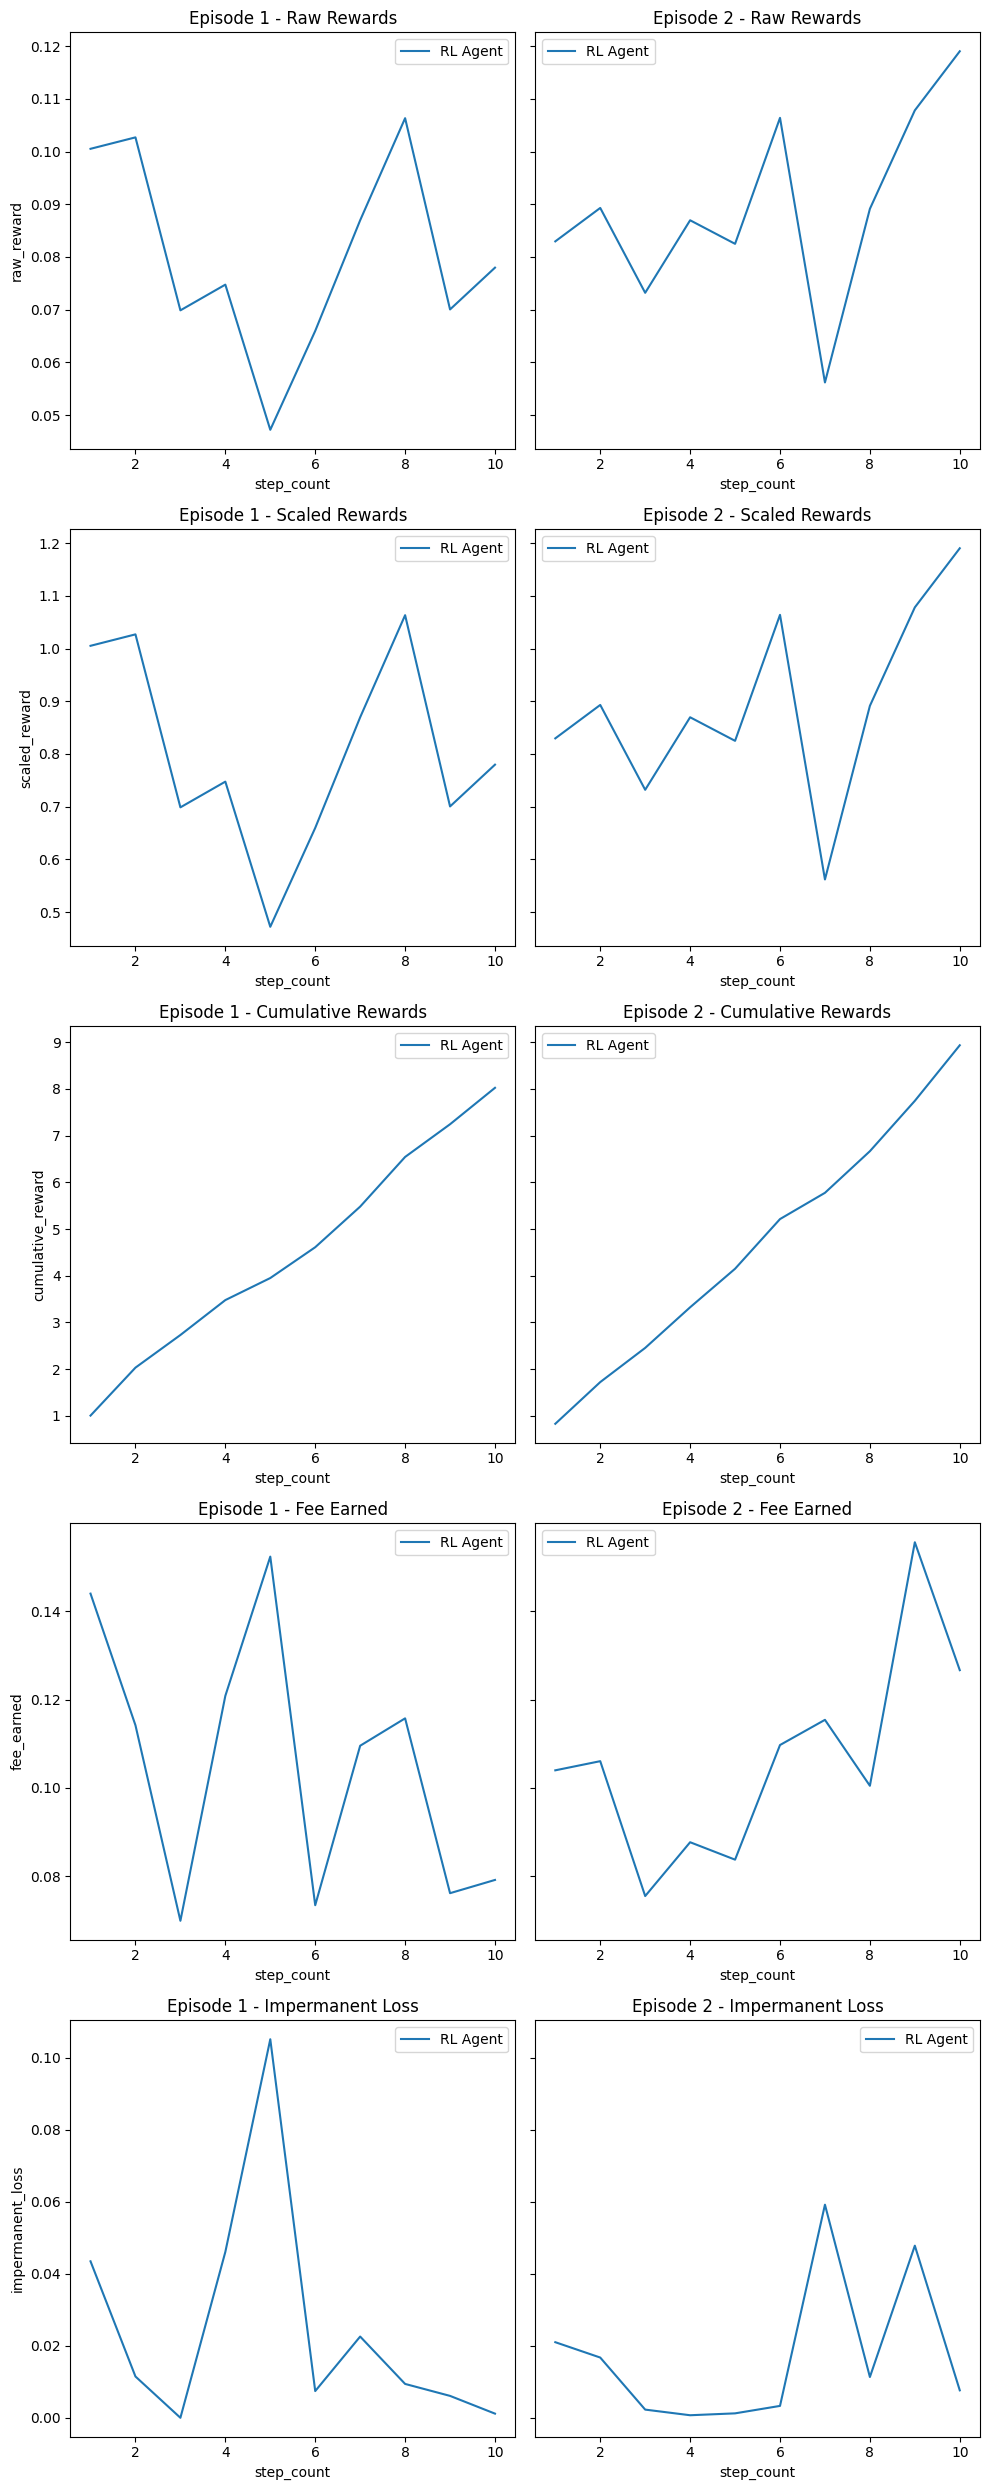

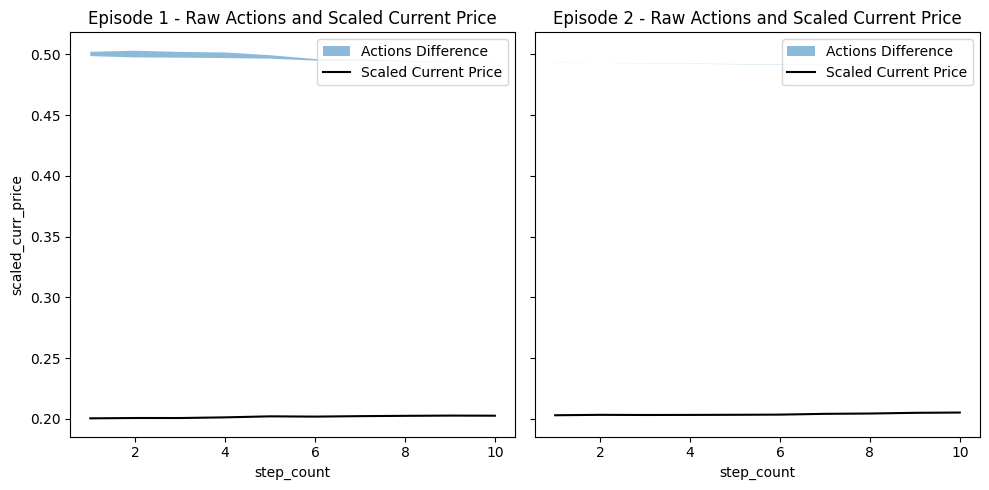

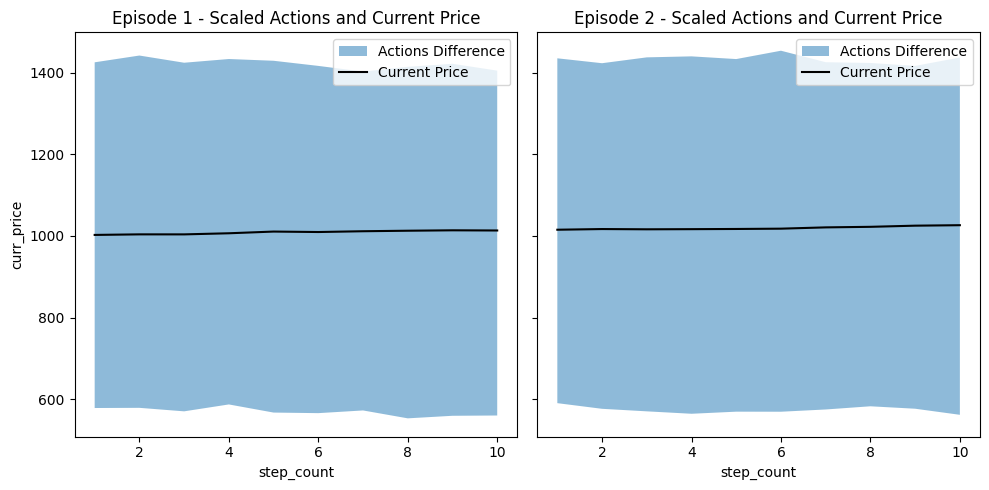

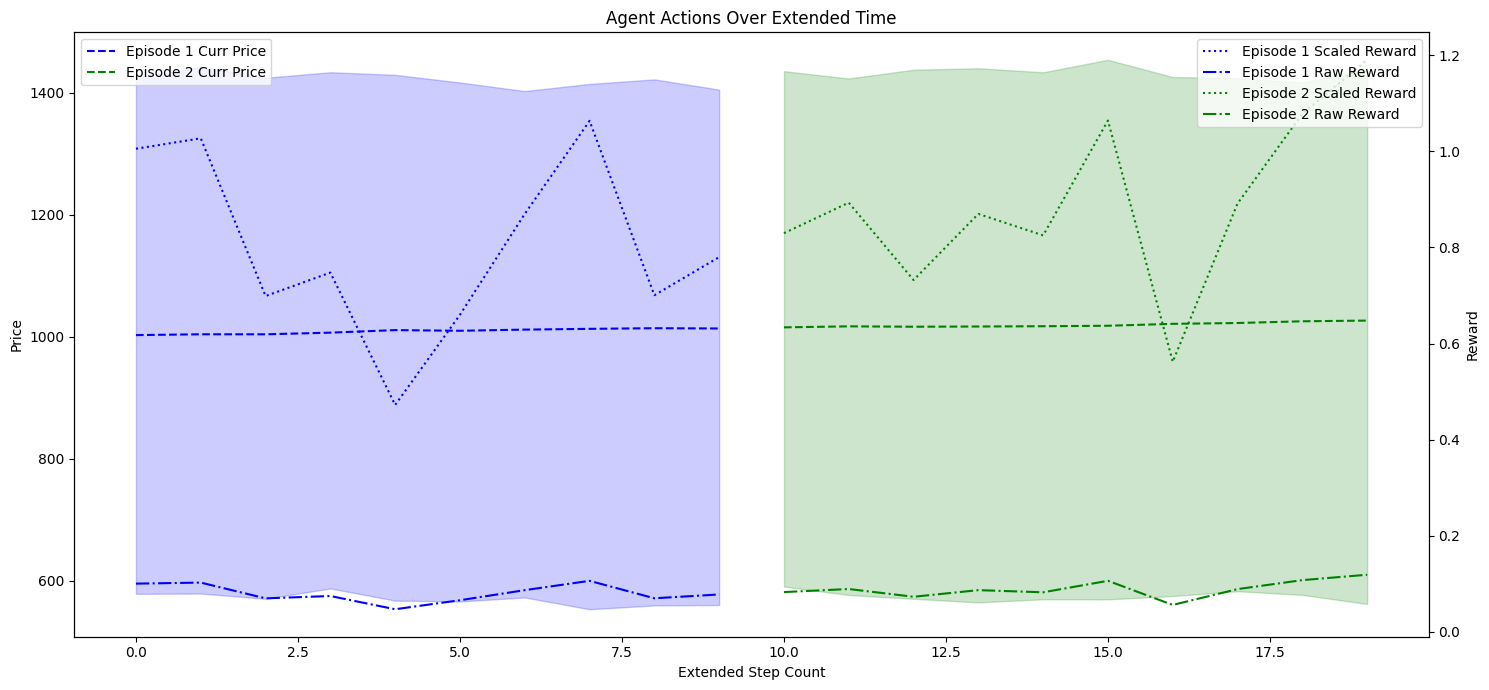

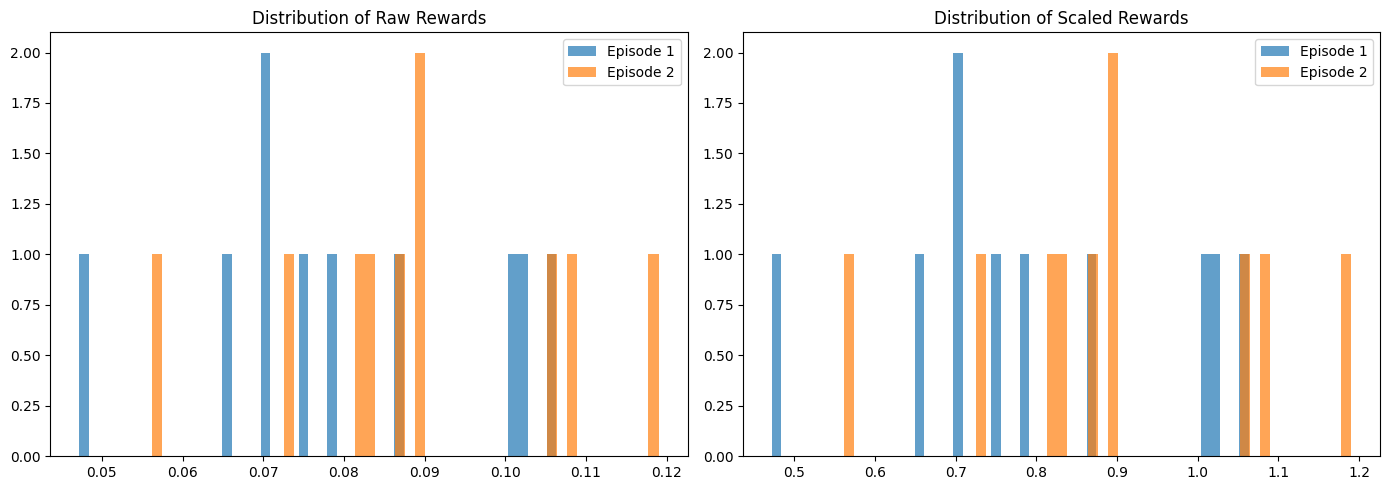

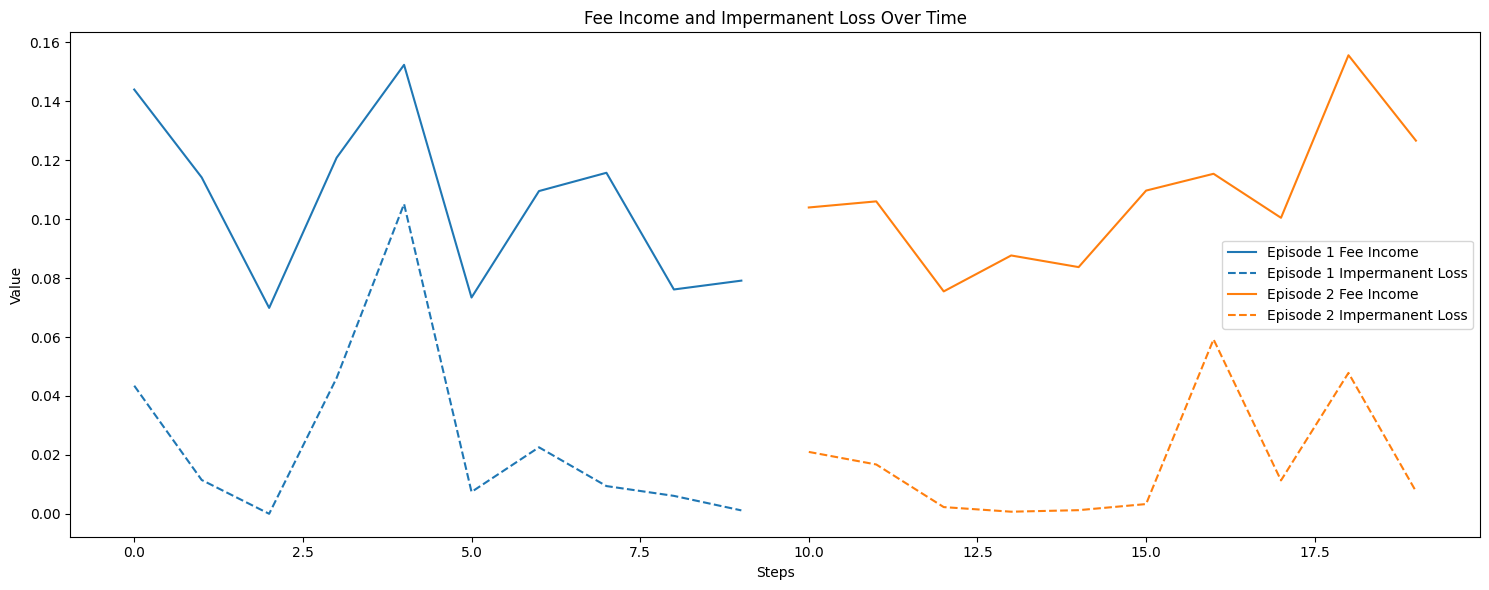

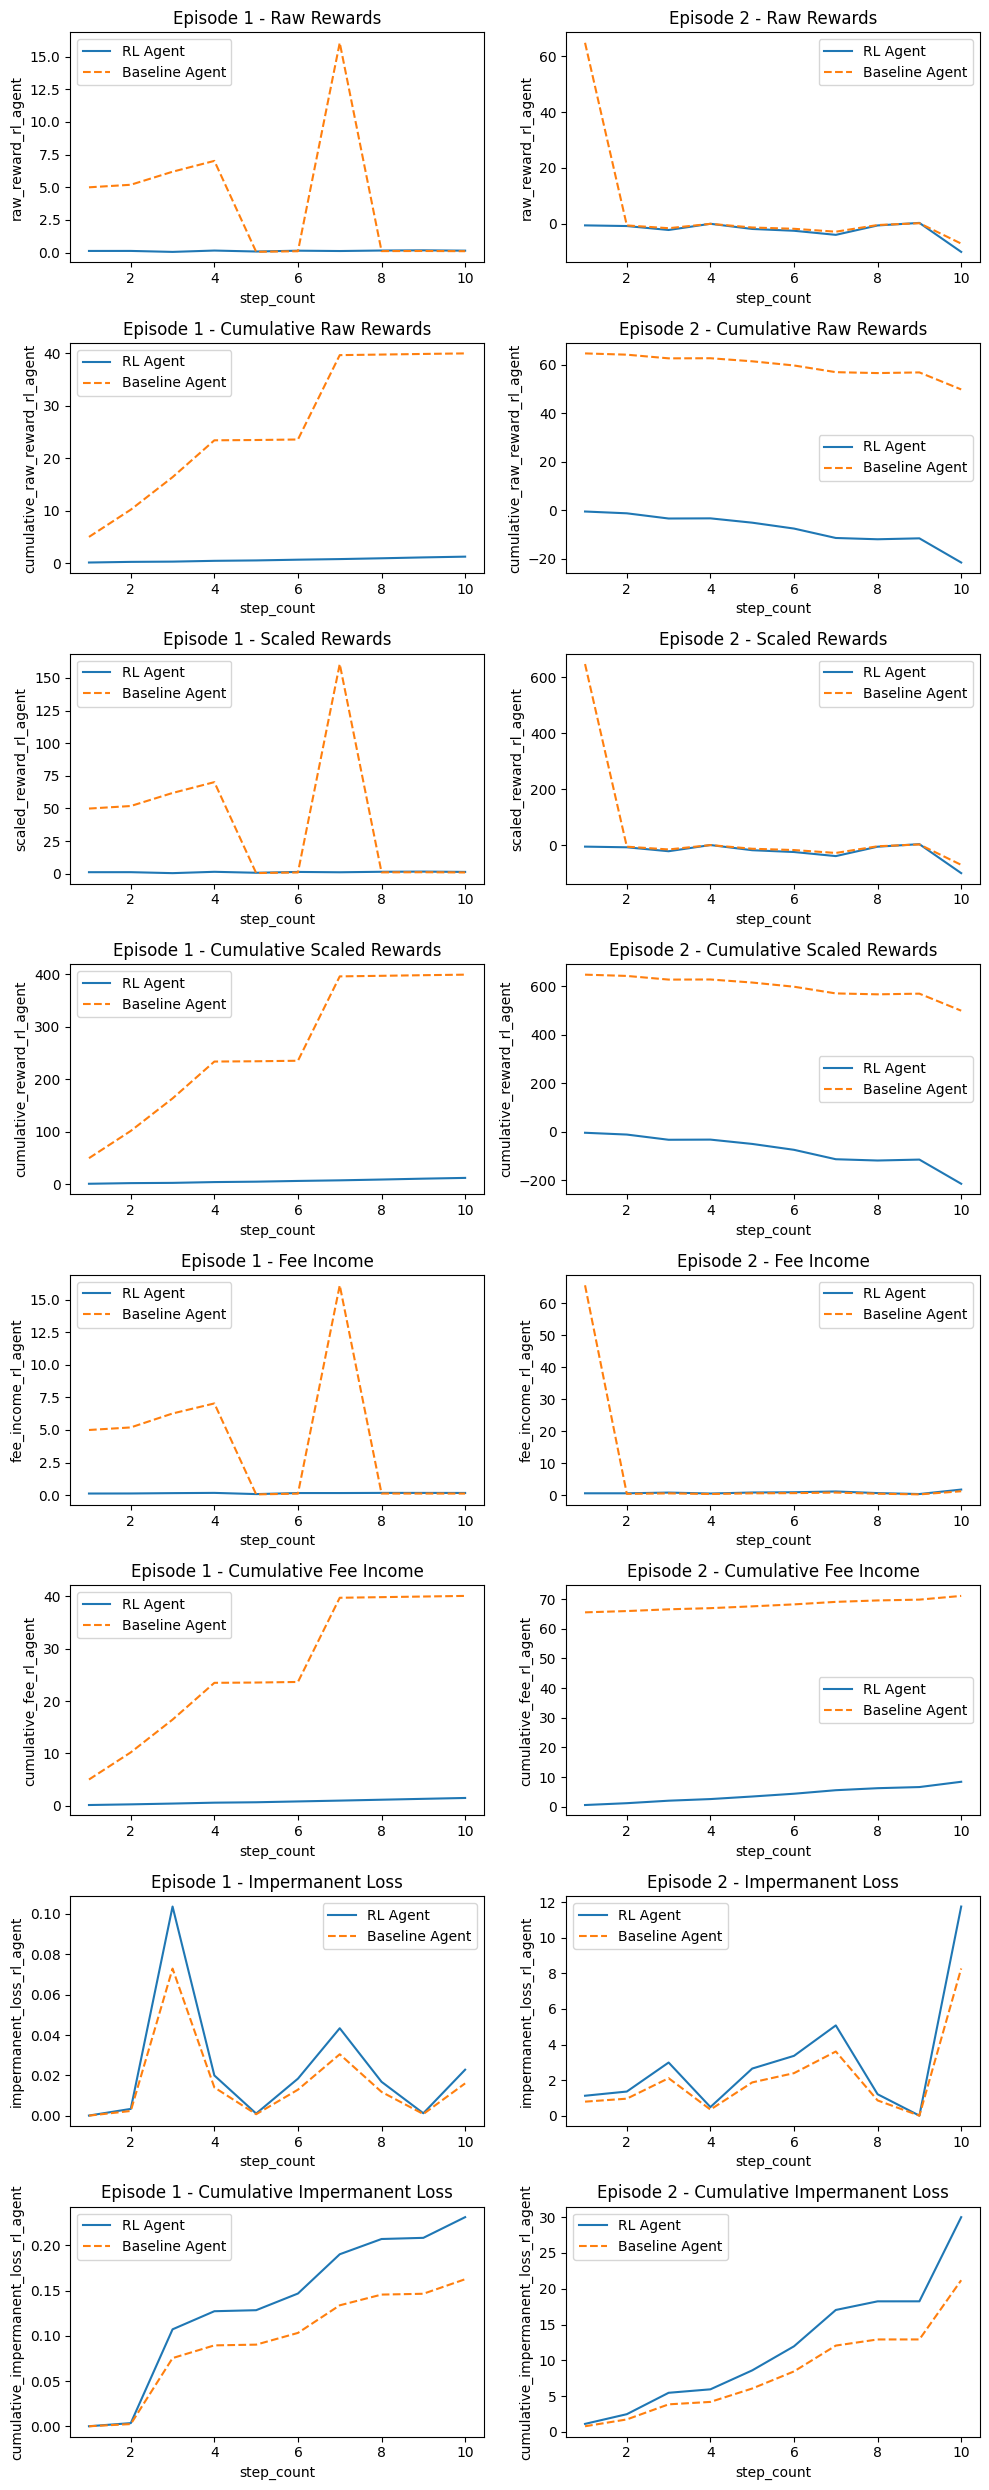

In [47]:
#'''
#import mlflow
#import mlflow.tensorflow

#mlflow.tensorflow.autolog()
#with mlflow.start_run():

    #train_data_log=[]
ddpg_model_name='model_storage/ddpg/ddpg_fazool'
ddpg_train_data_log=train_ddpg_agent(max_steps=10, n_episodes=2, model_name=ddpg_model_name,alpha=0.001, beta=0.001, input_dims=input_dims, tau=0.8, env=env,n_actions=n_actions, batch_size=50, training=True,agent_budget_usd=10000,use_running_statistics=False)
#!mlflow models serve -m "runs:/ddpg_31/model" -p 1234
#eval_data_log=[]
ddpg_eval_data_log=eval_ddpg_agent(eval_steps=10,eval_episodes=2,model_name=ddpg_model_name,percentage_range=0.6,agent_budget_usd=10000,use_running_statistics=False)
ddpg_training_vis(ddpg_train_data_log)
ddpg_eval_vis(ddpg_eval_data_log)
#'''

## PPO Interface

In [45]:
#'''
#train_data_log=[]
ppo_model_name='model_storage/ppo/ppo1_fazool'
ppo_train_data_log=train_ppo_agent(max_steps=10, n_episodes=2, model_name=ppo_model_name, n_actions=n_actions, observation_dims=input_dims,buffer_size=50,n_epochs=20, gamma=0.5, alpha=0.001, gae_lambda=0.75, policy_clip=0.6, max_grad_norm=0.6,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear')
#eval_data_log=[]
ppo_eval_data_log=eval_ppo_agent(eval_steps=10,eval_episodes=2,model_name=ppo_model_name,percentage_range=0.5,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear')
ppo_training_vis(ppo_train_data_log)
ppo_eval_vis(ppo_eval_data_log)
#'''

"\n#train_data_log=[]\nppo_model_name='model_storage/ppo/ppo_1_linear_action_transform'\nppo_train_data_log=train_ppo_agent(max_steps=200, n_episodes=5, model_name=ppo_model_name, n_actions=n_actions, observation_dims=input_dims,buffer_size=50,n_epochs=20, gamma=0.5, alpha=0.001, gae_lambda=0.75, policy_clip=0.6, max_grad_norm=0.6,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear')\n#eval_data_log=[]\nppo_eval_data_log=eval_ppo_agent(eval_steps=50,eval_episodes=3,model_name=ppo_model_name,percentage_range=0.5,agent_budget_usd=10000,use_running_statistics=False,action_transform='linear')\nppo_training_vis(ppo_train_data_log)\nppo_eval_vis(ppo_eval_data_log)\n"

## Strategy Interface

In [46]:
# Example pool state
pool_state = {
    'current_profit': 500,
    'price_out_of_range': False,
    'time_since_last_adjustment': 40000,
    'pool_volatility': 0.2
}

# Example user preferences
user_preferences = {
    'risk_tolerance': {'profit_taking': 50, 'stop_loss': -500},
    'investment_horizon': 7,  # days
    'liquidity_preference': {'adjust_on_price_out_of_range': True},
    'risk_aversion_threshold':0.1,
    'user_status':'new_user'
}
#pool="0x3416cf6c708da44db2624d63ea0aaef7113527c6" #USDC/USDT
#pool="0x6c6bc977e13df9b0de53b251522280bb72383700" #DAI/USDC
pool="0x4e68ccd3e89f51c3074ca5072bbac773960dfa36" #ETH/USDT
#pool="0x99ac8ca7087fa4a2a1fb6357269965a2014abc35" #WBTC/USDC
#pool="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed" #WBTC/ETH
strategy_action, ddpg_action,ppo_action = liquidity_strategy(user_preferences,pool_state,pool_id=pool,ddpg_agent_path='model_storage/ddpg/ddpg_1',ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm')
print(f"/nStartegy Action: {strategy_action}, /nDDPG Agent Action: {ddpg_action}, /nPPO Agent Action: {ppo_action}")

State Space: {'feeGrowthGlobal0X128': 1.492737479399626e+42, 'feeGrowthGlobal1X128': 3.101094570305874e+33, 'liquidity': 8.448108432920657e+18, 'token1Price': 2355.420419872435}
Obs Space: {'scaled_curr_price': 0.47108408397448703, 'scaled_liquidity': 0.08448108432920656, 'scaled_feeGrowthGlobal0x128': 149273747.93996263, 'scaled_feeGrowthGlobal1x128': 0.31010945703058745}


Pool selcted for this episode: BTC_USDT_3000
mnemonic: 'afraid demand drip document lyrics liberty liberty market wedding expect rocket poem'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x0182bb001543FF744e277383F22F6771dF467645'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x0182bb001543FF744e277383F22F6771dF467645'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'process dash rhythm frozen glimpse erase swear ancient bulk fat author point'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x6127a9Df0C38EA8c28E45caa6A7e695D560Aa5cd'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0x6127a9D

Liquidity Strategy Framework
1. User Profile Assessment
Risk Tolerance Assessment: Gauge the user's appetite for risk (low, medium, high) and set profit-taking and stop-loss thresholds accordingly.
Investment Horizon: Determine the duration the user plans to engage in liquidity provisioning (short-term, mid-term, long-term).
Liquidity Preference: Assess the user's preference for types of pools (e.g., stablecoin pairs vs. high-volatility pairs).
2. Market and Pool Analysis
Volatility Analysis: Use historical data to analyze the volatility of the pool. Higher volatility may require a more dynamic strategy.
Fee vs. Impermanent Loss Analysis: Assess the historical balance between fee income and impermanent loss in the pool.
Token Pair Correlation: Study the correlation between the assets in the pool and how it affects price movements and liquidity depth.
3. Integration of RL Agent Predictions
Predictive Modeling: Regularly run the DDPG and PPO agents to predict optimal liquidity ranges based on the current pool state.
Adjustment Frequency: Decide the frequency of querying the RL agents for adjustments based on market conditions and user preferences.
4. Strategy Implementation
Initiating Position: Enter the liquidity pool based on initial RL agent predictions and user preferences.
Continuous Monitoring: Set up a system to continuously monitor the pool's state and the performance of the liquidity position.
Adjustment Protocols:
Profit Taking: If the profit reaches the user's threshold, adjust or rebalance as per the RL agent's suggestions.
Price Range Exit: If the pool price moves out of the predicted range significantly, adjust the position.
Stop Loss: Exit the position if losses reach the user-defined stop-loss threshold.
Handling Volatility: In high volatility, reduce exposure or exit based on impermanent loss risk and market trends.
Regular Review and Rebalancing: Periodically review the position independent of the RL predictions and rebalance if necessary based on market shifts.

1. Initial Setup and User Input
User Interface: Develop a user interface where the user can select a pool, allocate a budget (e.g., 10000 USD), choose a time horizon, and specify risk preferences (risk aversion and tolerance).
Pool Selection: Allow the user to select a Uniswap V3 pool for liquidity provisioning.
User Preferences: Capture the user's risk tolerance, investment horizon, and other relevant preferences.
2. Initial Liquidity Provisioning
Predict Action: When a new user decides to add liquidity, the strategy uses both DDPG and PPO agents to predict the optimal liquidity range (price_lower and price_upper) based on the current state of the selected pool.
Action Selection: The strategy selects one of the predicted actions (from DDPG or PPO) to initiate the liquidity provisioning in the pool.
Execute Liquidity Provision: Add liquidity to the selected pool within the predicted range using the user's allocated budget.
3. Continuous Strategy Management
Data Fetching: Regularly (e.g., hourly) fetch data from the pool to monitor the state of the liquidity position and the pool's market conditions.
State Assessment: Assess the current state of the liquidity position in terms of profit/loss, whether the price is within the range, and other relevant metrics.
Decision Criteria: Define criteria for adjusting, maintaining, or exiting the position based on user preferences and real-time market data.
4. Ongoing Position Management
Rebalance Position: If the strategy determines that rebalancing is needed (e.g., price out of the current range or based on time interval), it again uses DDPG and PPO agents to predict a new optimal range and adjusts the position accordingly.
Maintain Position: If the current position is deemed optimal, the strategy will continue to hold the position without changes.
Exit Position: If the strategy identifies adverse market conditions or meets the user's risk parameters (like stop loss), it exits the position to protect the user's capital.
5. Strategy Execution Loop
Loop Implementation: Implement a loop that continuously monitors the pool state, re-evaluates the position, and executes the strategy's decisions (adjust, maintain, or exit) based on real-time data and user preferences.
6. User Feedback and Adjustment
Feedback Mechanism: Allow users to review their position performance and adjust their preferences if needed.
Adaptive Strategy: Ensure the strategy adapts to changes in user preferences and ongoing market developments.
